# Analysis of a bias-free network

A bias-free network operates on its input by applying an adaptive linear transform (adaptive, because the transform is dependent on the input image). In this notebook, we analyze the properties of this transform using singular value decomposition.


In [1]:
!pip install ipython==7.9.0

  Using cached ipython-7.9.0-py3-none-any.whl (775 kB)
  Using cached ipython-7.9.0-py3-none-any.whl (775 kB)
  Using cached prompt_toolkit-2.0.10-py3-none-any.whl (340 kB)
  Using cached prompt_toolkit-2.0.10-py3-none-any.whl (340 kB)
  Attempting uninstall: prompt-toolkit
    Found existing installation: prompt-toolkit 3.0.5
    Uninstalling prompt-toolkit-3.0.5:
  Attempting uninstall: prompt-toolkit
    Found existing installation: prompt-toolkit 3.0.5
    Uninstalling prompt-toolkit-3.0.5:
      Successfully uninstalled prompt-toolkit-3.0.5
      Successfully uninstalled prompt-toolkit-3.0.5
  Attempting uninstall: ipython
    Found existing installation: ipython 7.16.1
  Attempting uninstall: ipython
    Found existing installation: ipython 7.16.1
    Uninstalling ipython-7.16.1:
      Successfully uninstalled ipython-7.16.1
    Uninstalling ipython-7.16.1:
      Successfully uninstalled ipython-7.16.1


In [2]:
!pip install multiprocess

In [3]:
!pip install tqdm

In [4]:
import numpy as np
import matplotlib.pylab as plt
import matplotlib.patches as patches
import os
import torch
from skimage import io
from skimage.measure.simple_metrics import compare_psnr, compare_mse
import sys  
from utils import *
import time 

In [5]:
# %matplotlib notebook

In [6]:

%load_ext autoreload
%autoreload 2

In [7]:
# Paths for data, pretrained models, and precomputed performance measures
pretrained_base = './pretrained/'
precomputed_base = './precomputed/'
data_base = 'data/'

# Datasets available in the data folder
train_folder_path = os.path.join(data_base, 'Train400/')
test_folder_path = os.path.join(data_base, 'Test/Set68/')
set12_path = os.path.join(data_base, 'Test/Set12/')
kodak_path = os.path.join(data_base, 'Test/Kodak23/') 

### Choose a model 

Note: we provide four pre-trained models. You can train and analyze any other model (and its bias-free counterpart) using the train script provided in the repository. 

In [ ]:
# Choose a model (pre-trained options: 'dncnn', 'unet', 'rcnn', 'sdensenet')
model = 'dncnn' 

# Select the range of noise levels (stdev, relative to intensities in range [0,255]) 
# used during training (options are 0-10, 0-30, 0-55, 0-100).
l = 0   # lower bound of training range 
h = 100 # upper bound of training range

BF_CNN = load_model(os.path.join(pretrained_base, model, 'bias_free', str(l)+'-'+str(h)+'.pt'))

### Choose a clean image


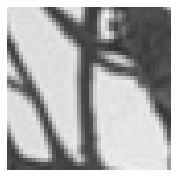

In [72]:
# choose a clean image (figure 4 in paper uses image_num=15)
image_num =15# 24
clean_im = single_image_loader(test_folder_path, image_num)

# Crop out a 40x40 patch (optional, helps for visibility.  Same values used for Figure 4 in paper).
clean_im = clean_im[100:140, 100:140]#
dim1, dim2 = clean_im.shape
f , axs = plt.subplots(1,1 , figsize=(3,3))    
axs.imshow(clean_im, 'gray', vmin=0, vmax = 1)
axs.axis('off');


In [ ]:
plt.hist(clean_im.flatten())

# Resize

In [ ]:
import scipy.ndimage

In [ ]:
clean_im_rs=scipy.ndimage.zoom(clean_im,5)

In [ ]:
np.shape(clean_im)

In [ ]:

residual_imgs = []

In [ ]:
# Compute the Jacobian, evaluated at a noisy version of the clean image selected above. 
# WARNING: slow computation! For a 40x40 patch, it can take between 1 and 2 minutes. 

noisy_im = add_noise2(clean_im.reshape(1,dim1,dim2), 90, 'S')[0][0] 

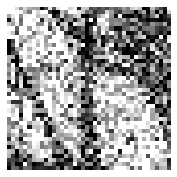

In [71]:
f , axs = plt.subplots(1,1 , figsize=(3,3))    
axs.imshow(noisy_im, 'gray', vmin=0, vmax = 1)
axs.axis('off');

In [ ]:
np.shape(noisy_im)

In [ ]:
# start_time_total = time.time()
# scaling = .00001
# A = calc_jacobian(scaling*noisy_im,BF_CNN)
# print("---- Jacobian computation time --- %s seconds ---" % (time.time() - start_time_total))

# Hessian via multiprocessing

In [ ]:
from multiprocess import Pool

In [ ]:
from multiprocess import set_start_method
try:
    set_start_method('spawn')
except RuntimeError:
    pass

In [ ]:
from hessian_util import *

In [ ]:
import torch.multiprocessing as mp

In [ ]:
from torch.multiprocessing import set_start_method
try:
    set_start_method('spawn')
except RuntimeError:
    pass

In [ ]:
from functools import partial

In [ ]:

from itertools import product

In [ ]:
%%time
hess_all = []
if __name__ == '__main__':
    for ci in range(0,40,2):

        xc = 80
        
        jarr = np.arange(xc)
        cl = list(ci*np.ones([40],dtype=int))
        cl.extend(list((ci+1)*np.ones([40],dtype=int)))

        coord_gpu = [(ii*8//xc,np.mod(ii,40),cl[ii]) for ii in jarr]
        print(coord_gpu)
        
        # im = .00001*noisy_im
        im = noisy_im
        # model = BF_CNN
    #     im=torch.tensor(im.astype('float32'),requires_grad=True).unsqueeze(0).unsqueeze(0).cuda()

        BF_CNN.share_memory()
    #     imc.share_memory()
        #p.daemon = True
        # jacob=[]
        # p = mp.Process(target=calc_hessian_mp,args=(imc.detach(),jacob,))
        # out2=p.start()
        # out=p.join()
        hess_mp = []
        func = partial(calc_hessian_mpf, im)
    #     jarr = np.arange(40)
        nreps = len(coord_gpu)
    #     coord_gpu = [(0, 15), (0, 16), (1,17), (1,18)]
        print(nreps)
        with Pool(processes=nreps) as pool:
    #         hess_mp = pool.map(calc_hessian_mpf, imc.detach())
    #         hess_mp = pool.starmap(func, product([0],jarr))
            hess_mp = pool.starmap(func, coord_gpu)
    #         hess_mp = pool.apply_async(func, [15,16,17,18,19,20,21,22])
        print(ci,' done')
        hess_all.extend(hess_mp)

36  done
[(0, 0, 38), (0, 1, 38), (0, 2, 38), (0, 3, 38), (0, 4, 38), (0, 5, 38), (0, 6, 38), (0, 7, 38), (0, 8, 38), (0, 9, 38), (1, 10, 38), (1, 11, 38), (1, 12, 38), (1, 13, 38), (1, 14, 38), (1, 15, 38), (1, 16, 38), (1, 17, 38), (1, 18, 38), (1, 19, 38), (2, 20, 38), (2, 21, 38), (2, 22, 38), (2, 23, 38), (2, 24, 38), (2, 25, 38), (2, 26, 38), (2, 27, 38), (2, 28, 38), (2, 29, 38), (3, 30, 38), (3, 31, 38), (3, 32, 38), (3, 33, 38), (3, 34, 38), (3, 35, 38), (3, 36, 38), (3, 37, 38), (3, 38, 38), (3, 39, 38), (4, 0, 39), (4, 1, 39), (4, 2, 39), (4, 3, 39), (4, 4, 39), (4, 5, 39), (4, 6, 39), (4, 7, 39), (4, 8, 39), (4, 9, 39), (5, 10, 39), (5, 11, 39), (5, 12, 39), (5, 13, 39), (5, 14, 39), (5, 15, 39), (5, 16, 39), (5, 17, 39), (5, 18, 39), (5, 19, 39), (6, 20, 39), (6, 21, 39), (6, 22, 39), (6, 23, 39), (6, 24, 39), (6, 25, 39), (6, 26, 39), (6, 27, 39), (6, 28, 39), (6, 29, 39), (7, 30, 39), (7, 31, 39), (7, 32, 39), (7, 33, 39), (7, 34, 39), (7, 35, 39), (7, 36, 39), (7, 37, 3

In [ ]:
def curvature_nd(ygrad,yhess):    

    sx = np.zeros([len(ygrad),len(ygrad)+1])
    sxeye = np.eye(len(ygrad))

    sx[:len(ygrad),:len(ygrad)]=sxeye
    sx[:,len(ygrad)]=ygrad

    FF = np.matmul(sx,sx.T)
    
    V =  np.eye(len(ygrad))
    xv = ygrad
    sn0 = np.matmul(V,xv)
    sn = np.zeros(np.shape(sn0)[0]+1)
    sn[:-1]=sn0
    sn[-1]=-1.
    C = sn/np.linalg.norm(sn)
    
#     SF = np.zeros_like(FF)
    
#     for ii in range(len(ygrad)):
#         for jj in range(len(ygrad)):
#             zvec = np.zeros([len(ygrad)+1,1])
#             zvec[-1]=yhess[ii][jj]
#             SF[ii,jj]=np.matmul(zvec[:,0],C)            
    SF=np.reshape(np.array(yhess).flatten()*C[-1],[1600,1600])
    if 1:#np.max(np.isnan(SF).flatten()) or np.max(np.isnan(FF).flatten()):
        SO = np.linalg.solve(FF,SF)#,rcond=-1)#[0]
        
    return SO

In [ ]:
hess_arr = []
for ii in range(1600):
    hess_arr.extend(hess_all[ii][0])

In [ ]:
hess_arr = np.array(hess_arr)

In [ ]:
np.shape(hess_arr)

(1600, 1600)

In [ ]:
hess_cv = hess_arr

In [ ]:
kd,KM=np.linalg.eig(hess_cv)

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


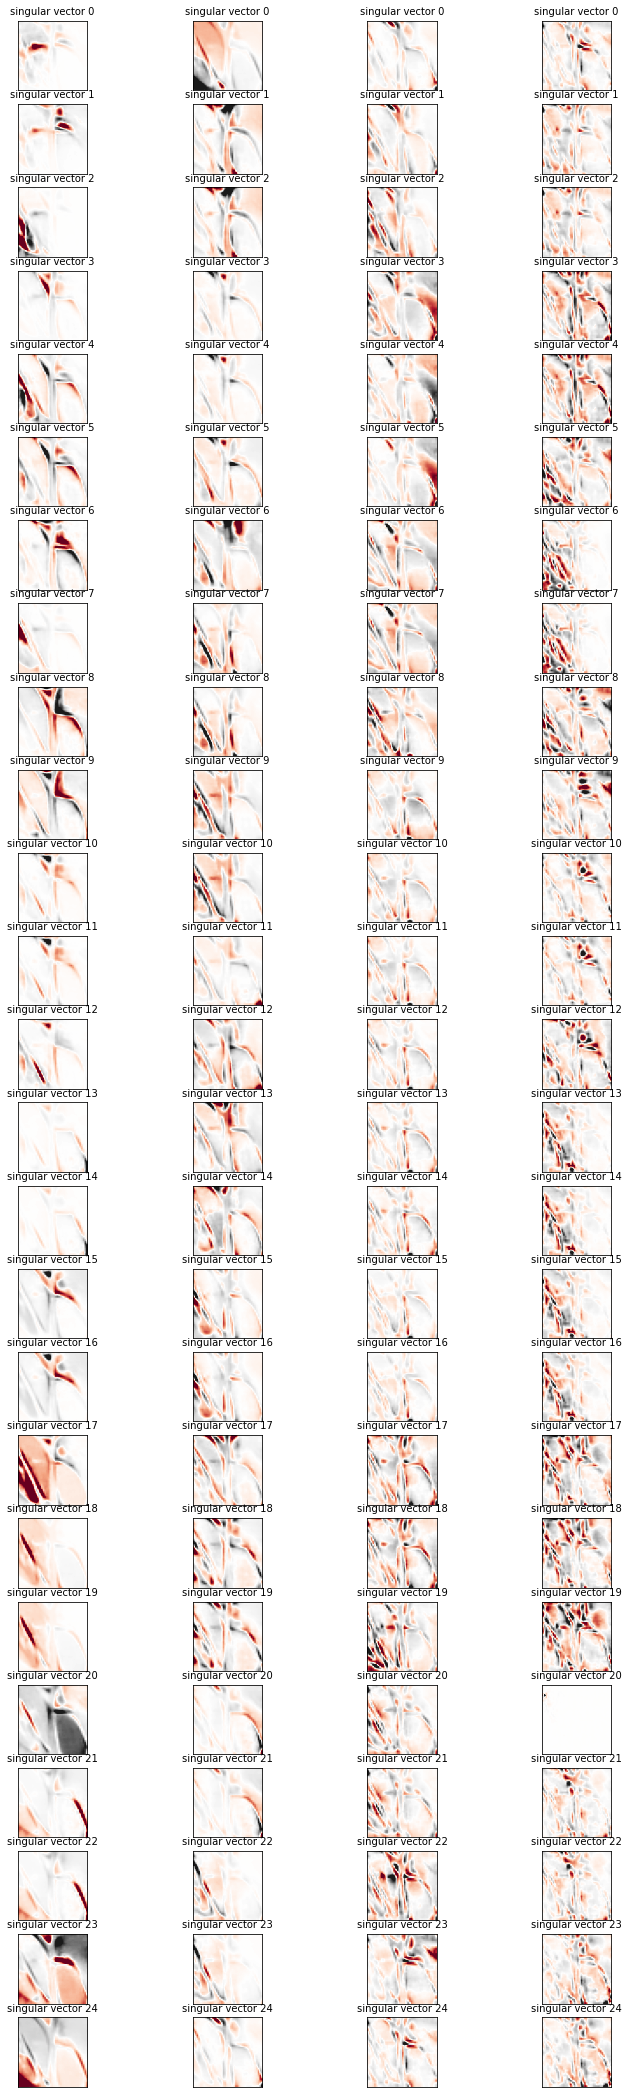

In [ ]:
kd,KM=np.linalg.eig(hess_cv)
# Show some example singular vectors with large singular values
sing_vect_n = np.add(0,[0,2,4,6,10,12,14,16,20,22,24,26]) # indices of the singular vectors for visualization 

mm=25
sing_vect_n = np.arange(4*mm)
# sing_vect_n = list(-1*np.arange(10))
N = 1600 # dimensionality of the space
# Bnp =SO#[:,np.argsort(np.linalg.norm(SO,axis=1))]#B.cpu().numpy()
# kd,KM=np.linalg.eig(SO);
Bnp=np.real(KM)
f , axs = plt.subplots(len(sing_vect_n)//4, 4,figsize=(12,38))    
plt.subplots_adjust()
for j in range(4):
    for i in range(len(sing_vect_n)//4):
        u = Bnp[:,sing_vect_n[(len(sing_vect_n)//4)*j+i]]
        
        limit =  max(np.abs(np.min( u)), np.abs(np.max(u)))
        v = 0.#V[sing_vect_n[i],:]
        axs[i,j].imshow(u.reshape(dim1,dim2), 'RdGy', vmin=-limit/2, vmax = limit/2)
        axs[i,j].set_title('singular vector '+str(sing_vect_n[i]), fontsize = 10, fontname= 'Times New Roman')
        axs[i,j].tick_params(bottom=False,left=False,labelleft=False,labelbottom=False)
#         axs[i,j].set_xlabel(r'$v^Tu$ =  '+str(np.round( np.dot(u,v) ,2))+ '\n $s =$ '+str(np.round(KM[sing_vect_n[i]],1)),
#                           fontsize = 10, fontname= 'Times New Roman');

In [89]:
SOall = []
for xi in range(1600):
    
    SO = curvature_nd(hess_all[xi][0][0],hess_all[xi][1])
    SOall.extend(np.subtract(SO,np.mean(SO,axis=0)))
    
    
    if np.mod(xi,100)==0:
        print(xi)
#             else:

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500


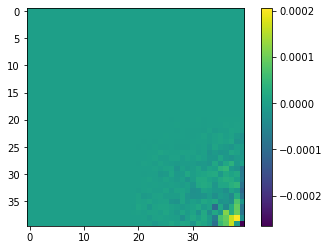

In [104]:
plt.imshow(np.reshape(np.mean(SO,axis=0),[40,40]))
plt.colorbar()

In [92]:
# hess_arr = []
# for ii in range(1600):
#     hess_arr.extend(hess_all[ii][1])

In [94]:
hess_arr = np.array(SOall)

In [95]:
hess_arr = np.subtract(hess_arr,np.mean(hess_arr,axis=0))

In [96]:
hess_cv = np.matmul(hess_arr.T,hess_arr)

In [97]:
kd,KM=np.linalg.eig(hess_cv)

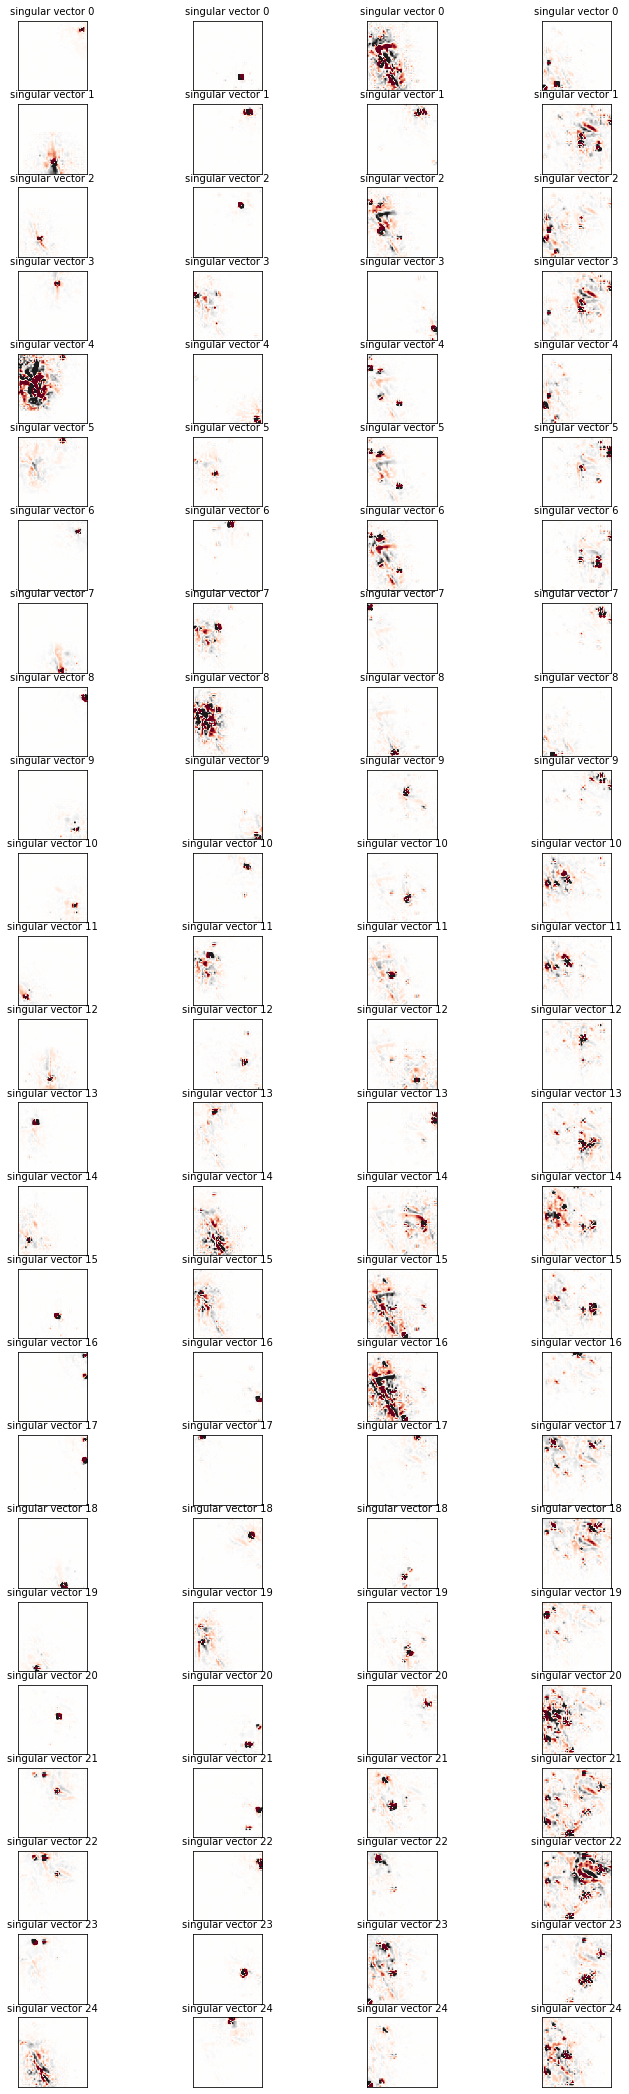

In [98]:
# Show some example singular vectors with large singular values
# sing_vect_n = np.add(0,[0,2,4,6,10,12,14,16,20,22,24,26]) # indices of the singular vectors for visualization 

mm=25
sing_vect_n = 0+np.arange(4*mm)
# sing_vect_n = list(-1*np.arange(10))
N = 1600 # dimensionality of the space
# Bnp =SO#[:,np.argsort(np.linalg.norm(SO,axis=1))]#B.cpu().numpy()
# kd,KM=np.linalg.eig(SO);
Bnp=KM
f , axs = plt.subplots(len(sing_vect_n)//4, 4,figsize=(12,38))    
plt.subplots_adjust()
for j in range(4):
    for i in range(len(sing_vect_n)//4):
        u = Bnp[:,sing_vect_n[(len(sing_vect_n)//4)*j+i]]
        
        limit =  .2*max(np.abs(np.min( u)), np.abs(np.max(u)))
        v = 0.#V[sing_vect_n[i],:]
        axs[i,j].imshow(u.reshape(dim1,dim2), 'RdGy', vmin=-limit/2, vmax = limit/2)
        axs[i,j].set_title('singular vector '+str(sing_vect_n[i]), fontsize = 10, fontname= 'Times New Roman')
        axs[i,j].tick_params(bottom=False,left=False,labelleft=False,labelbottom=False)
#         axs[i,j].set_xlabel(r'$v^Tu$ =  '+str(np.round( np.dot(u,v) ,2))+ '\n $s =$ '+str(np.round(KM[sing_vect_n[i]],1)),
#                           fontsize = 10, fontname= 'Times New Roman');

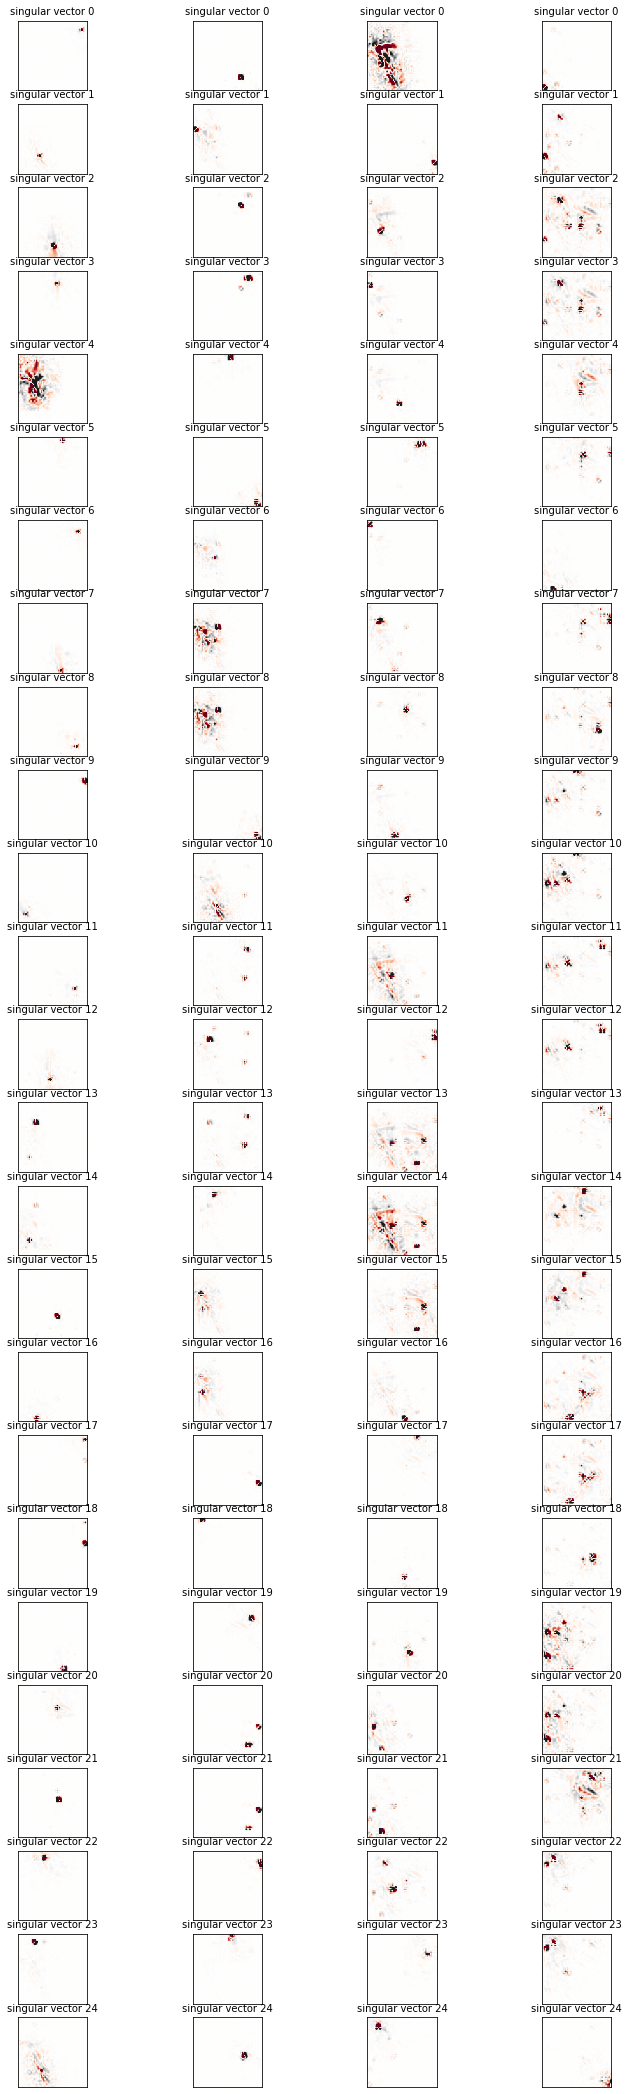

In [44]:
# only hessian

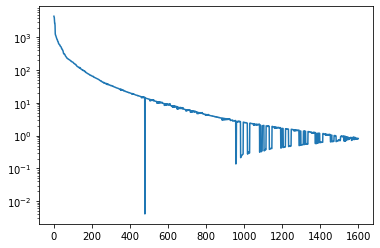

In [103]:
plt.plot(kd[:])
plt.yscale('log')


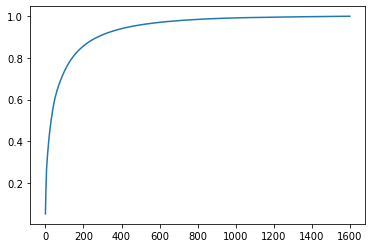

In [100]:
plt.plot(np.cumsum(kd[:])/np.sum(kd[:]))

In [101]:
len([ii for ii in np.cumsum(kd[:])/np.sum(kd[:]) if ii < .95])

447